In [1]:
import os
# os.environ["THEANO_FLAGS"] = "mode=FAST_RUN, device=cpu, optimizer=fast_compile, floatX=float32"

import pymc3 as pm
import numpy as np
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style('oceans16')

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using cuDNN version 7005 on context None
Mapped name None to device cuda: GeForce GTX 1050 (0000:01:00.0)
C:\Users\ares\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Example of a (fake) clinical trial for an "IQ-enhancing" drug. 

In [2]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

In [22]:
y1 = np.array(drug).astype(np.float32)
y2 = np.array(placebo).astype(np.float32)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['drug']*len(drug), ['placebo']*len(placebo)]))
# woah np.r_ is what i've been looking for for ages

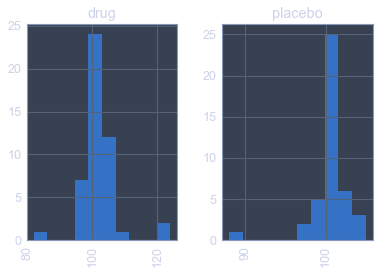

In [4]:
y.hist('value', by='group'); # Also interesting

Statistical tests are often done using a Student-t distribution, which is more sensitive to outliers than the Normal distribution. It has three parameters: its mean, precision and degrees of freedom. For large degrees of freedom, the distribution converges to the normal distribution. Otherwise, it has a heavier tail. 

We will specify priors over the three parameters of the t distribution:

In [5]:
# We specify the prior mean to be the mean of the datapoints (hmm). 
# The standard deviation of the prior is two times the std of the data (also hmmm)
mu_m = y.value.mean()
mu_s = y.value.std() * 2

In [6]:
with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=mu_m, sd=mu_s)
    group2_mean = pm.Normal('group2_mean', mu=mu_m, sd=mu_s)

In [7]:
# We could choose whatever to be our prior over the standard deviation, but it's sensible to
# keep it within bounds of the IQ range, since it is a standardized measure. In general,
# it's good to incorporate as much (actual) knowledge in our model as we can

sigma_low, sigma_high = 1, 10
with model:
    group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high)
    group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high)
    

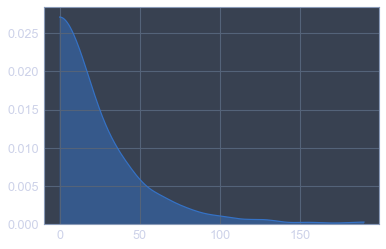

In [8]:
# We can make the prior for the degrees of freedom nu an exponential distribution with a mean of 30
# " this allocates high prior probability over the regions
# of the parameter that describe the range from normal to heavy-tailed
# data under the Student-T distribution.

with model:
    nu = pm.Exponential('v_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=1000), shade=0.5);

In [9]:
# PyMC3 uses precision instead of sd for the t distribution, so ugh
with model:
    lambda_1 = group1_std**-2
    lambda_2 = group2_std**-2
    
    group1 = pm.StudentT('drug', nu=nu, mu=group1_mean, lam=lambda_1, observed=y1)
    group2 = pm.StudentT('placebo', nu=nu, mu=group2_mean, lam=lambda_2, observed=y2)

Now the fun part! We can calculate the comparisons between the distributions to evaluate the effect of our drug. We can do this using deterministic functions 

In [10]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', 
                                  diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))
    # This is a d-prime 

Fitus! 

In [11]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\ares\Anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:36<00:00, 69.10it/s]


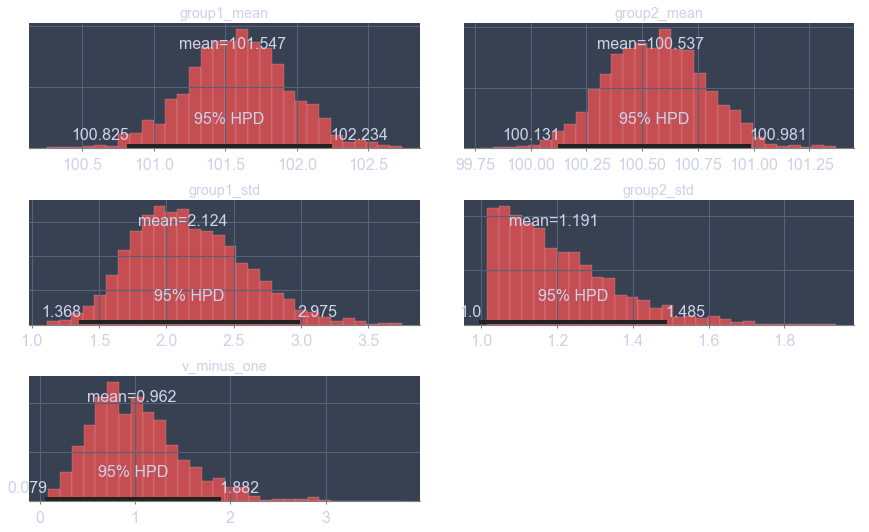

In [12]:
pm.plot_posterior(trace, varnames=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'v_minus_one'],
                  color='r');

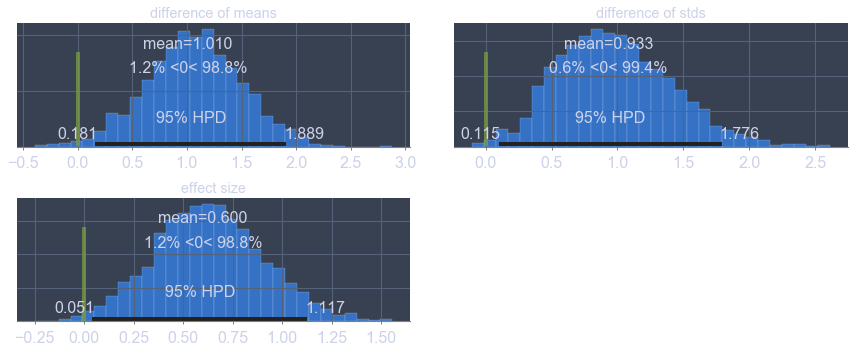

In [13]:
pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='b');

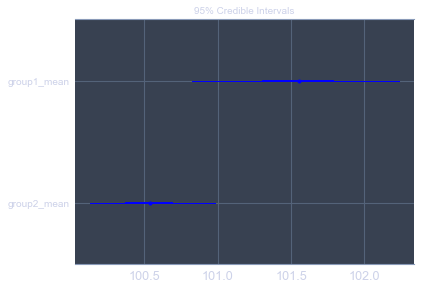

In [14]:
pm.forestplot(trace, varnames=['group1_mean', 'group2_mean'])

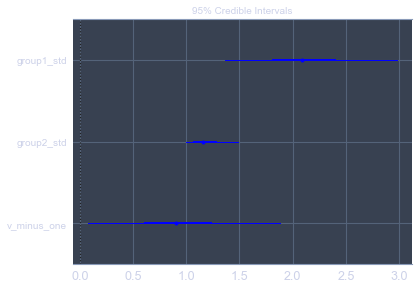

In [15]:
pm.forestplot(trace, varnames=['group1_std',
                               'group2_std',
                               'v_minus_one']);

In [16]:
pm.summary(trace,varnames=['difference of means', 'difference of stds', 'effect size'])



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.010            0.435            0.011            [0.181, 1.889]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.143          0.719          1.016          1.301          1.873


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.933            0.431            0.008            [0.115, 1.776]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.176          0.620          0.901          1.215          1.858


effect size:

  Mean             SD               MC Error         95% HPD int

In [17]:
p = (trace['difference of means'][500:] > 0).mean()
p0 = (trace['difference of means'][500:] < 0).mean()
print("Probability of difference being true is {}\n\
Probability of difference being null is {}".format(p, p0))

Probability of difference being true is 0.9866666666666667
Probability of difference being null is 0.013333333333333334


Let's attempt to do a trick: we can create a whole bunch of Bayesian models, and instead of choosing one or averaging them, we can pose this as a hierarchical problem: we can switch between models by having a Categorical prior on models. There are some tradeoffs with sampling, since we update parameters of each model when they're evaluated on the other model, and this can lead to drifting depending on how the priors are placed. Let's take two priors on the distribution means (bias?):

In [18]:
from pymc3.step_methods import smc
from tempfile import mkdtemp

In [37]:
n_chains = 1000
models = []
traces = []
priors = (mu_m, mu_m+1) # our priors for mu

for ind in priors:
    test_folder = mkdtemp(prefix='SMC_TEST')
    with pm.Model() as new_model:
        group1_mean = pm.Normal('group1_mean', mu=ind, sd=mu_s)
        group2_mean = pm.Normal('group2_mean', mu=ind, sd=mu_s)
        
        group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high, transform=None)
        group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high, transform=None)
        nu = pm.Exponential('v_minus_one', 1/29., transform=None) + 1
        
        lambda_1 = group1_std**-2
        lambda_2 = group2_std**-2
    
        group1 = pm.StudentT('drug', nu=nu, mu=group1_mean, lam=lambda_1, observed=y1)
        group2 = pm.StudentT('placebo', nu=nu, mu=group2_mean, lam=lambda_2, observed=y2)
        
        diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
        effect_size = pm.Deterministic('effect size', 
                                  diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))
    # This is a d-prime 
#         trace2 = pm.smc.sample_smc(n_steps=2000, n_chains=n_chains, homepath=test_folder)
        trace2 = pm.SMC(n_chains=n_chains)
        models.append(new_model)
        traces.append(trace2)

C:\Users\ares\Anaconda3\lib\site-packages\pymc3\step_methods\smc.py:120: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Adding model likelihood to RVs!


Calculate Bayes Factor!!

In [39]:
pm.traceplot(traces[0])

TypeError: 'SMC' object is not subscriptable

In [44]:
waic = pm.waic(trace, model)

In [45]:
waic.WAIC

436.74933477277534

In [31]:
pm.SMC?